# $\fbox{2-3}$ 傷病条件付き新入院発生率・新入院平均在院日数

### 準備 & 作成したデータの読み込み

In [1]:
# グラフを移動拡大縮小したい場合
%matplotlib notebook
# グラフをインラインで表示
# %matplotlib inline

import gc

import mylibs.mylib1 as mylib1  # 本書 1 章の関数群を含む自作ライブラリ
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

# 表示する行・列の数を設定
pd.options.display.max_rows = 6
pd.options.display.max_columns = 10

# matplotlib のフォントを設定
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
df_info = pd.read_csv('./pseudo_medical/records/excl_bp/info.csv')
df_commons = pd.read_csv('./pseudo_medical/records/excl_bp/commons.csv')
df_diseases = pd.read_csv('./pseudo_medical/records/excl_bp/diseases.csv')

### ALB table, Exposure table を作成

In [3]:
# 分析開始時点 (2010年1月)
start_study_t = 2010
# 分析終了時点 (2019年12月)
end_study_t = 2019.999

npa_obs_ym = mylib1.create_npa_obs_ym(start_study_t, end_study_t)
df_info = mylib1.convert_ym_to_t_in_info(df_info)
df_alb_table = mylib1.create_alb_table_from_info(npa_obs_ym, df_info)
df_exposure_table = mylib1.create_exposure_table_from_alb_table(
                        npa_obs_ym, df_alb_table)

In [4]:
df_alb_table

,iid,sex,family,birth_ym,start_obs_ym,...,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,...,67,67,67,67,67
1,i000001,F,2,1972/11,2010/01,...,46,46,46,47,47
2,i000002,M,1,1978/03,2010/01,...,41,41,41,41,41
...,...,...,...,...,...,...,...,...,...,...,...
4812,i008260,M,1,1987/02,2019/06,...,32,32,32,32,32
4813,i008263,M,1,1980/08,2010/01,...,39,39,39,39,39
4814,i008264,M,2,1952/06,2010/01,...,67,67,67,67,67


In [5]:
df_exposure_table

,iid,sex,family,birth_ym,start_obs_ym,...,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,...,0,0,0,0,0
1,i000001,F,2,1972/11,2010/01,...,1,1,1,1,1
2,i000002,M,1,1978/03,2010/01,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4812,i008260,M,1,1987/02,2019/06,...,1,1,1,1,1
4813,i008263,M,1,1980/08,2010/01,...,0,0,0,0,0
4814,i008264,M,2,1952/06,2010/01,...,0,0,0,0,0


### event table の作成

In [6]:
df_diseases.head()

,iid,rid,first_ym,icd10_code
0,i000000,r00000001,2010/01,D50
1,i000000,r00000002,2010/02,H60
2,i000000,r00000003,2010/02,S00
3,i000000,r00000004,2010/03,G00
4,i000000,r00000005,2010/04,C00


In [7]:
df_event_table = df_exposure_table.copy()
df_event_table[npa_obs_ym] = 0
# がん（ICD-10コード：C00-D09）のみに限定
in_cancer = ('C00' <= df_diseases['icd10_code']) \
    & (df_diseases['icd10_code'] <= 'D09')
df_cancers = df_diseases[in_cancer]

df_cancers

,iid,rid,first_ym,icd10_code
4,i000000,r00000005,2010/04,C00
14,i000000,r00000015,2011/02,C00
21,i000000,r00000022,2011/04,C00
...,...,...,...,...
433271,i008263,r00433272,2015/12,C00
433281,i008263,r00433282,2016/05,C00
433309,i008264,r00433310,2010/09,C00


In [8]:
print(len(df_cancers))
print(len(df_cancers['rid'].unique()))

21677
21677


In [9]:
df_commons.head()

,iid,rid,ym,receipt_type,admission_ym,days
0,i000000,r00000001,2010/01,outpatient,-,1
1,i000000,r00000002,2010/02,outpatient,-,1
2,i000000,r00000003,2010/02,outpatient,-,1
3,i000000,r00000004,2010/03,outpatient,-,1
4,i000000,r00000005,2010/04,outpatient,-,1


In [10]:
# 入院レコードのみに限定
df_hosps = df_commons[df_commons['receipt_type'] == 'inpatient']

df_hosps

,iid,rid,ym,receipt_type,admission_ym,days
374,i000003,r00000375,2010/11,inpatient,2010/11,2
480,i000006,r00000481,2013/07,inpatient,2013/07,11
679,i000012,r00000680,2010/08,inpatient,2010/08,7
...,...,...,...,...,...,...
433001,i008254,r00433002,2012/07,inpatient,2012/04,30
433002,i008254,r00433003,2012/08,inpatient,2012/04,19
433065,i008255,r00433066,2013/02,inpatient,2013/02,1


In [11]:
# rid で内部結合 (inner join) する。
# iid が両方に存在するので、カラム名が iid_x と iid_y になってしまう。
df_cancer_hosps = pd.merge(df_cancers, df_hosps,
                           on='rid', how='inner')

df_cancer_hosps

,iid_x,rid,first_ym,icd10_code,iid_y,ym,receipt_type,admission_ym,days
0,i000041,r00001967,2010/12,C00,i000041,2010/12,inpatient,2010/12,15
1,i000041,r00001968,2010/12,C00,i000041,2011/01,inpatient,2010/12,8
2,i000041,r00001991,2012/04,C00,i000041,2012/04,inpatient,2012/04,15
...,...,...,...,...,...,...,...,...,...
405,i008206,r00430074,2014/11,C00,i008206,2014/11,inpatient,2014/11,2
406,i008219,r00430924,2019/09,C00,i008219,2019/09,inpatient,2019/09,4
407,i008229,r00431303,2011/02,C00,i008229,2011/02,inpatient,2011/02,5


In [12]:
del df_cancer_hosps['iid_y']
df_cancer_hosps.columns = ['iid', 'rid', 'first_ym', 'icd10_code', 'ym',
                           'receipt_type', 'admission_ym', 'days']

df_cancer_hosps

,iid,rid,first_ym,icd10_code,ym,receipt_type,admission_ym,days
0,i000041,r00001967,2010/12,C00,2010/12,inpatient,2010/12,15
1,i000041,r00001968,2010/12,C00,2011/01,inpatient,2010/12,8
2,i000041,r00001991,2012/04,C00,2012/04,inpatient,2012/04,15
...,...,...,...,...,...,...,...,...
405,i008206,r00430074,2014/11,C00,2014/11,inpatient,2014/11,2
406,i008219,r00430924,2019/09,C00,2019/09,inpatient,2019/09,4
407,i008229,r00431303,2011/02,C00,2011/02,inpatient,2011/02,5


In [13]:
dfg = df_cancer_hosps.groupby(['iid', 'admission_ym'])
df_cancer_admissions = dfg['days'].sum().reset_index()

df_cancer_admissions

,iid,admission_ym,days
0,i000041,2010/12,23
1,i000041,2012/04,26
2,i000162,2019/01,10
...,...,...,...
299,i008206,2014/11,2
300,i008219,2019/09,4
301,i008229,2011/02,5


In [14]:
print(len(df_cancer_admissions))
print(len(df_cancer_admissions['iid'].unique()))

302
276


In [15]:
for ym in npa_obs_ym:
    is_ym = (df_cancer_admissions['admission_ym'] == ym)
    iid_in_ym = df_cancer_admissions.loc[is_ym, 'iid'].values
    in_iid_in_ym = df_event_table['iid'].isin(iid_in_ym)
    df_event_table.loc[in_iid_in_ym, ym] = 1

df_event_table.head()

,iid,sex,family,birth_ym,start_obs_ym,...,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,...,0,0,0,0,0
1,i000001,F,2,1972/11,2010/01,...,0,0,0,0,0
2,i000002,M,1,1978/03,2010/01,...,0,0,0,0,0
3,i000003,M,2,1989/03,2010/01,...,0,0,0,0,0
4,i000006,M,1,1973/11,2010/04,...,0,0,0,0,0


In [16]:
df_event_table[npa_obs_ym].sum().sum()

302

### ALB ごとにエクスポージャとイベント件数を集計

In [17]:
df_summary = mylib1.count_exposure_and_event(npa_obs_ym, df_alb_table,
                                             df_exposure_table, df_event_table)

df_summary

,sex,alb,exposure,event
0,M,0,1120,0
1,M,1,1344,0
2,M,2,1570,0
...,...,...,...,...
197,F,97,0,0
198,F,98,0,0
199,F,99,0,0


In [18]:
df_summary['alb_mid'] = df_summary.alb // 5 * 5 + 2

df_summary.head(10)

,sex,alb,exposure,event,alb_mid
0,M,0,1120,0,2
1,M,1,1344,0,2
2,M,2,1570,0,2
...,...,...,...,...,...
7,M,7,2095,0,7
8,M,8,2174,0,7
9,M,9,2286,0,7


In [19]:
df_summary_5x = df_summary.groupby(['sex', 'alb_mid'])[
    'exposure', 'event'].sum()
df_summary_5x = mylib1.estimate_rate(df_summary_5x, e=0.05)
df_summary_5x = df_summary_5x.reset_index()

df_summary_5x

,sex,alb_mid,exposure,event,obs_rate,LCL,UCL
0,F,2,7808,0,0.0,0.0,0.000492
1,F,7,10149,0,0.0,0.0,0.000378
2,F,12,8935,0,0.0,0.0,0.000430
...,...,...,...,...,...,...,...
37,M,87,0,0,NaN,NaN,NaN
38,M,92,0,0,NaN,NaN,NaN
39,M,97,0,0,NaN,NaN,NaN


### 真の月次がん入院発生率の作成

In [20]:
df_true_hosp_rate = pd.read_csv('./public_stats/processed/ps_admission.csv')

df_true_hosp_rate.head()

,sex,alb_min,alb_max,A00,C00,...,O00,P00,Q00,R00,S00
0,M,0.0,0.0,0.0,0.0,...,0.0,0.015865,0.000000,0.0,0.000000
1,M,1.0,4.0,0.0,0.0,...,0.0,0.000000,0.001291,0.0,0.001291
2,M,5.0,9.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000969
3,M,10.0,14.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000937
4,M,15.0,19.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000847


In [21]:
def get_true_cancer_admission_rate(df_true_hosp_rate, sex, alb):
    is_sex = (df_true_hosp_rate.sex == sex)
    more_alb_min = (df_true_hosp_rate.alb_min <= alb)
    less_alb_max = (alb <= df_true_hosp_rate.alb_max)
    ix = is_sex & more_alb_min & less_alb_max
    return df_true_hosp_rate.loc[ix, 'C00'].values[0]


get_true_cancer_admission_rate(df_true_hosp_rate, 'M', 50)

0.0012723977

In [22]:
df_summary_5x['true_rate'] = 0
for i in df_summary_5x.index:
    (sex, alb) = df_summary_5x.loc[i, ['sex', 'alb_mid']]
    df_summary_5x.loc[i, 'true_rate'] = get_true_cancer_admission_rate(
        df_true_hosp_rate, sex, alb)

df_summary_5x

,sex,alb_mid,exposure,event,obs_rate,LCL,UCL,true_rate
0,F,2,7808,0,0.0,0.0,0.000492,0.000000
1,F,7,10149,0,0.0,0.0,0.000378,0.000000
2,F,12,8935,0,0.0,0.0,0.000430,0.000000
...,...,...,...,...,...,...,...,...
37,M,87,0,0,NaN,NaN,NaN,0.006248
38,M,92,0,0,NaN,NaN,NaN,0.006248
39,M,97,0,0,NaN,NaN,NaN,0.006248


<IPython.core.display.Javascript object>


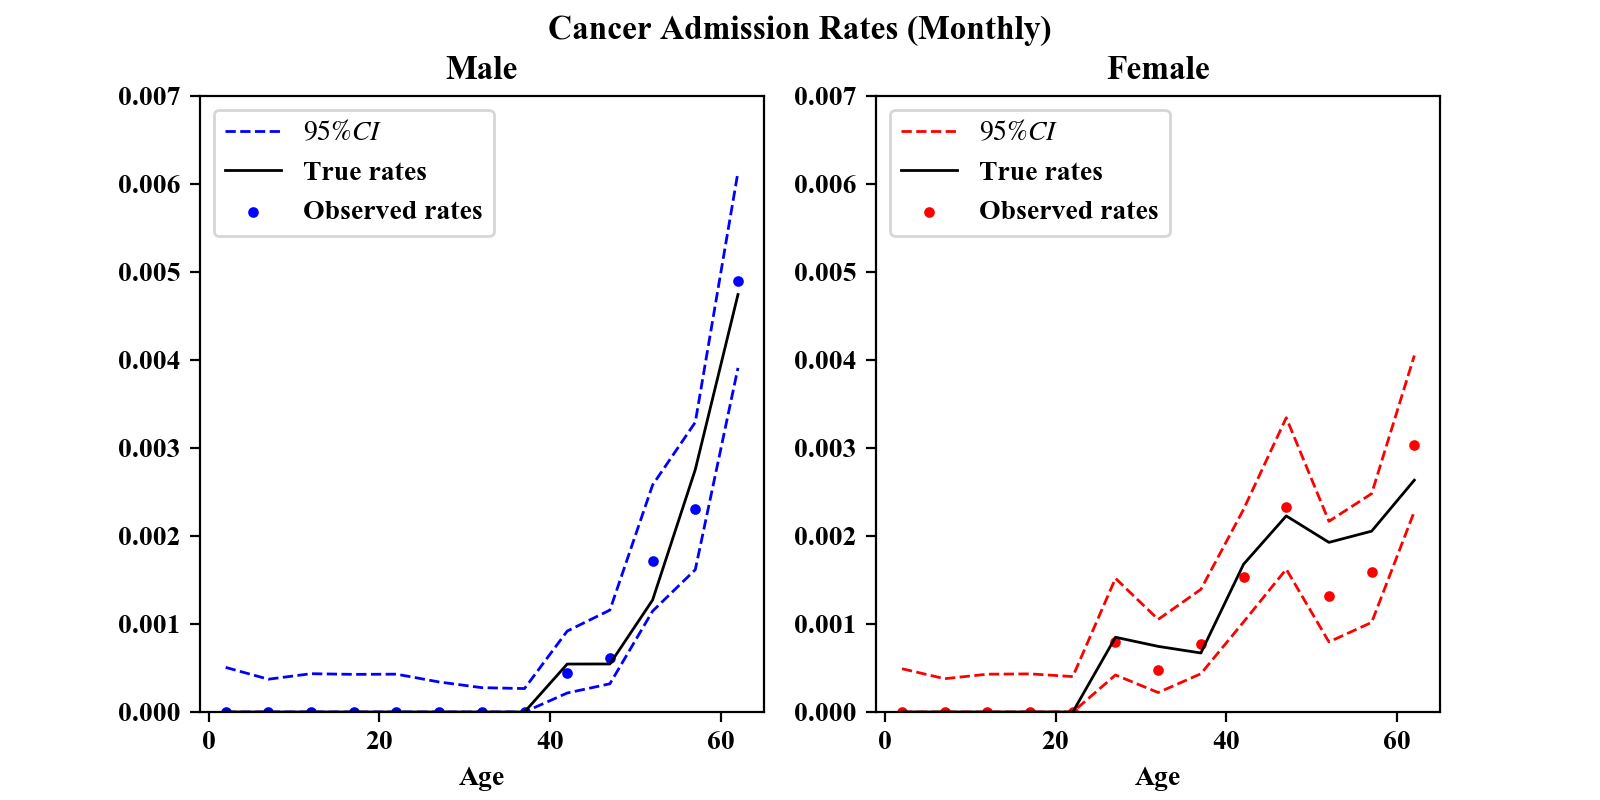

Text(0.5, 0.98, 'Cancer Admission Rates (Monthly)')

In [23]:
df = df_summary_5x.loc[(df_summary_5x.alb_mid < 65)]
df_M = df.loc[df.sex == 'M']
df_F = df.loc[df.sex == 'F']


def plot_rates(ax, df_sex, color):
    ax.scatter(df_sex.alb_mid, df_sex.obs_rate,
               c=color, s=8, label='Observed rates')
    ax.plot(df_sex.alb_mid, df_sex.LCL, c=color,
            ls='--', lw=1, label=r'$95\% CI$')
    ax.plot(df_sex.alb_mid, df_sex.UCL, c=color, ls='--', lw=1)
    ax.plot(df_sex.alb_mid, df_sex.true_rate,
            c='k', ls='-', lw=1, label='True rates')
    ax.legend(loc='upper left')
    ax.set_ylim(0, 0.007)


fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
plot_rates(ax1, df_M, 'b')
ax1.set_title('Male')
ax1.set_xlabel('Age')

ax2 = fig.add_subplot(122)
plot_rates(ax2, df_F, 'r')
ax2.set_title('Female')
ax2.set_xlabel('Age')

fig.suptitle('Cancer Admission Rates (Monthly)')

### がん新入院平均在院日数

In [24]:
df_cancer_admissions

,iid,admission_ym,days
0,i000041,2010/12,23
1,i000041,2012/04,26
2,i000162,2019/01,10
...,...,...,...
299,i008206,2014/11,2
300,i008219,2019/09,4
301,i008229,2011/02,5


In [25]:
df_days_table = df_event_table.copy()

# 入院日数
for i in df_cancer_admissions.index:
    iid = df_cancer_admissions.loc[i, 'iid']
    ym = df_cancer_admissions.loc[i, 'admission_ym']
    days = df_cancer_admissions.loc[i, 'days']
    i_for_df_days_table = df_days_table[df_days_table['iid'] == iid].index[0]
    df_days_table.loc[i_for_df_days_table, ym] = days

df_days_table.head()

,iid,sex,family,birth_ym,start_obs_ym,...,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,...,0,0,0,0,0
1,i000001,F,2,1972/11,2010/01,...,0,0,0,0,0
2,i000002,M,1,1978/03,2010/01,...,0,0,0,0,0
3,i000003,M,2,1989/03,2010/01,...,0,0,0,0,0
4,i000006,M,1,1973/11,2010/04,...,0,0,0,0,0


In [26]:
ym_cols = df_days_table.columns[10:]
df_days_table[ym_cols].max()

2010/01     2
2010/02    32
2010/03    25
           ..
2019/10    35
2019/11    27
2019/12     0
Length: 120, dtype: int64

### ALB ごとに在院日数を集計

In [27]:
df_alb_table

,iid,sex,family,birth_ym,start_obs_ym,...,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,...,67,67,67,67,67
1,i000001,F,2,1972/11,2010/01,...,46,46,46,47,47
2,i000002,M,1,1978/03,2010/01,...,41,41,41,41,41
...,...,...,...,...,...,...,...,...,...,...,...
4812,i008260,M,1,1987/02,2019/06,...,32,32,32,32,32
4813,i008263,M,1,1980/08,2010/01,...,39,39,39,39,39
4814,i008264,M,2,1952/06,2010/01,...,67,67,67,67,67


In [28]:
ym_cols

Index(['2010/01', '2010/02', '2010/03', '2010/04', '2010/05', '2010/06',
       '2010/07', '2010/08', '2010/09', '2010/10',
       ...
       '2019/03', '2019/04', '2019/05', '2019/06', '2019/07', '2019/08',
       '2019/09', '2019/10', '2019/11', '2019/12'],
      dtype='object', length=120)

In [29]:
def get_days_sum(df_alb_table, df_days_table, sex, alb):
    ym_cols = df_alb_table.columns[10:]
    is_sex = np.array(df_days_table.sex == sex).reshape(len(df_days_table), 1)
    is_alb = np.array(df_alb_table[ym_cols] == alb)
    return (is_sex * is_alb * df_days_table[ym_cols]).sum().sum()


sex = 'M'
alb = 50
get_days_sum(df_alb_table, df_days_table, sex, alb)

50

In [30]:
df_summary['total_days'] = 0  # 列の作成
for i in df_summary.index:
    (sex, alb) = df_summary.loc[i, ['sex', 'alb']]
    df_summary.loc[i, 'total_days'] = get_days_sum(
        df_alb_table, df_days_table, sex, alb)

df_summary

,sex,alb,exposure,event,alb_mid,total_days
0,M,0,1120,0,2,0
1,M,1,1344,0,2,0
2,M,2,1570,0,2,0
...,...,...,...,...,...,...
197,F,97,0,0,97,0
198,F,98,0,0,97,0
199,F,99,0,0,97,0


In [31]:
print(df_summary.total_days.sum())
print(df_days_table[ym_cols].sum().sum())

3848
3848


In [32]:
df_summary_5x = df_summary.groupby(['sex', 'alb_mid'])[
    'exposure', 'event', 'total_days'].sum()
df_summary_5x = mylib1.estimate_rate(df_summary_5x, e=0.05)
df_summary_5x = df_summary_5x.reset_index()

df_summary_5x

,sex,alb_mid,exposure,event,total_days,obs_rate,LCL,UCL
0,F,2,7808,0,0,0.0,0.0,0.000492
1,F,7,10149,0,0,0.0,0.0,0.000378
2,F,12,8935,0,0,0.0,0.0,0.000430
...,...,...,...,...,...,...,...,...
37,M,87,0,0,0,NaN,NaN,NaN
38,M,92,0,0,0,NaN,NaN,NaN
39,M,97,0,0,0,NaN,NaN,NaN


In [33]:
df_summary_5x['avg_days'] = df_summary_5x.total_days / df_summary_5x.event

df_summary_5x

,sex,alb_mid,exposure,event,total_days,obs_rate,LCL,UCL,avg_days
0,F,2,7808,0,0,0.0,0.0,0.000492,NaN
1,F,7,10149,0,0,0.0,0.0,0.000378,NaN
2,F,12,8935,0,0,0.0,0.0,0.000430,NaN
...,...,...,...,...,...,...,...,...,...
37,M,87,0,0,0,NaN,NaN,NaN,NaN
38,M,92,0,0,0,NaN,NaN,NaN,NaN
39,M,97,0,0,0,NaN,NaN,NaN,NaN


### 真のがん入院平均在院日数の作成

In [34]:
df_true_days = pd.read_csv('./public_stats/processed/ps_days.csv')

df_true_days.head()

,sex,alb_min,alb_max,A00,C00,...,O00,P00,Q00,R00,S00
0,M,0.0,0.0,4.5,9.3,...,0.0,11.3,16.1,4.0,2.6
1,M,1.0,4.0,3.8,12.1,...,0.0,38.7,7.5,3.1,1.7
2,M,5.0,9.0,7.7,16.0,...,0.0,8.2,7.6,2.9,4.1
3,M,10.0,14.0,3.9,19.2,...,0.0,5.2,16.7,4.8,7.8
4,M,15.0,19.0,5.3,15.2,...,0.0,0.0,22.4,3.2,8.2


In [35]:
def get_true_cancer_days(df_true_days, sex, alb):
    is_sex = (df_true_days.sex == sex)
    more_alb_min = (df_true_days.alb_min <= alb)
    less_alb_max = (alb <= df_true_days.alb_max)
    ix = is_sex & more_alb_min & less_alb_max
    return df_true_days.loc[ix, 'C00'].values[0]


get_true_cancer_days(df_true_days, 'M', 50)

14.9

In [36]:
df_summary_5x['true_days'] = 0  # 列の追加
for i in df_summary_5x.index:
    (sex, alb) = df_summary_5x.loc[i, ['sex', 'alb_mid']]
    df_summary_5x.loc[i, 'true_days'] = get_true_cancer_days(
        df_true_days, sex, alb)

df_summary_5x

,sex,alb_mid,exposure,event,total_days,obs_rate,LCL,UCL,avg_days,true_days
0,F,2,7808,0,0,0.0,0.0,0.000492,NaN,14.3
1,F,7,10149,0,0,0.0,0.0,0.000378,NaN,11.3
2,F,12,8935,0,0,0.0,0.0,0.000430,NaN,19.0
...,...,...,...,...,...,...,...,...,...,...
37,M,87,0,0,0,NaN,NaN,NaN,NaN,26.3
38,M,92,0,0,0,NaN,NaN,NaN,NaN,26.3
39,M,97,0,0,0,NaN,NaN,NaN,NaN,26.3


In [37]:
from scipy.stats import gamma
e = 0.05
with np.errstate(invalid='ignore'):
    df_summary_5x['days_LCL'] = gamma.ppf(e/2, df_summary_5x['event'],
                                          0, df_summary_5x['avg_days']
                                          ) / df_summary_5x['event']
    df_summary_5x['days_UCL'] = gamma.ppf(1 - e/2, df_summary_5x['event'],
                                          0, df_summary_5x['avg_days']
                                          ) / df_summary_5x['event']

df_summary_5x

,sex,alb_mid,exposure,event,total_days,...,UCL,avg_days,true_days,days_LCL,days_UCL
0,F,2,7808,0,0,...,0.000492,NaN,14.3,NaN,NaN
1,F,7,10149,0,0,...,0.000378,NaN,11.3,NaN,NaN
2,F,12,8935,0,0,...,0.000430,NaN,19.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
37,M,87,0,0,0,...,NaN,NaN,26.3,NaN,NaN
38,M,92,0,0,0,...,NaN,NaN,26.3,NaN,NaN
39,M,97,0,0,0,...,NaN,NaN,26.3,NaN,NaN


<IPython.core.display.Javascript object>


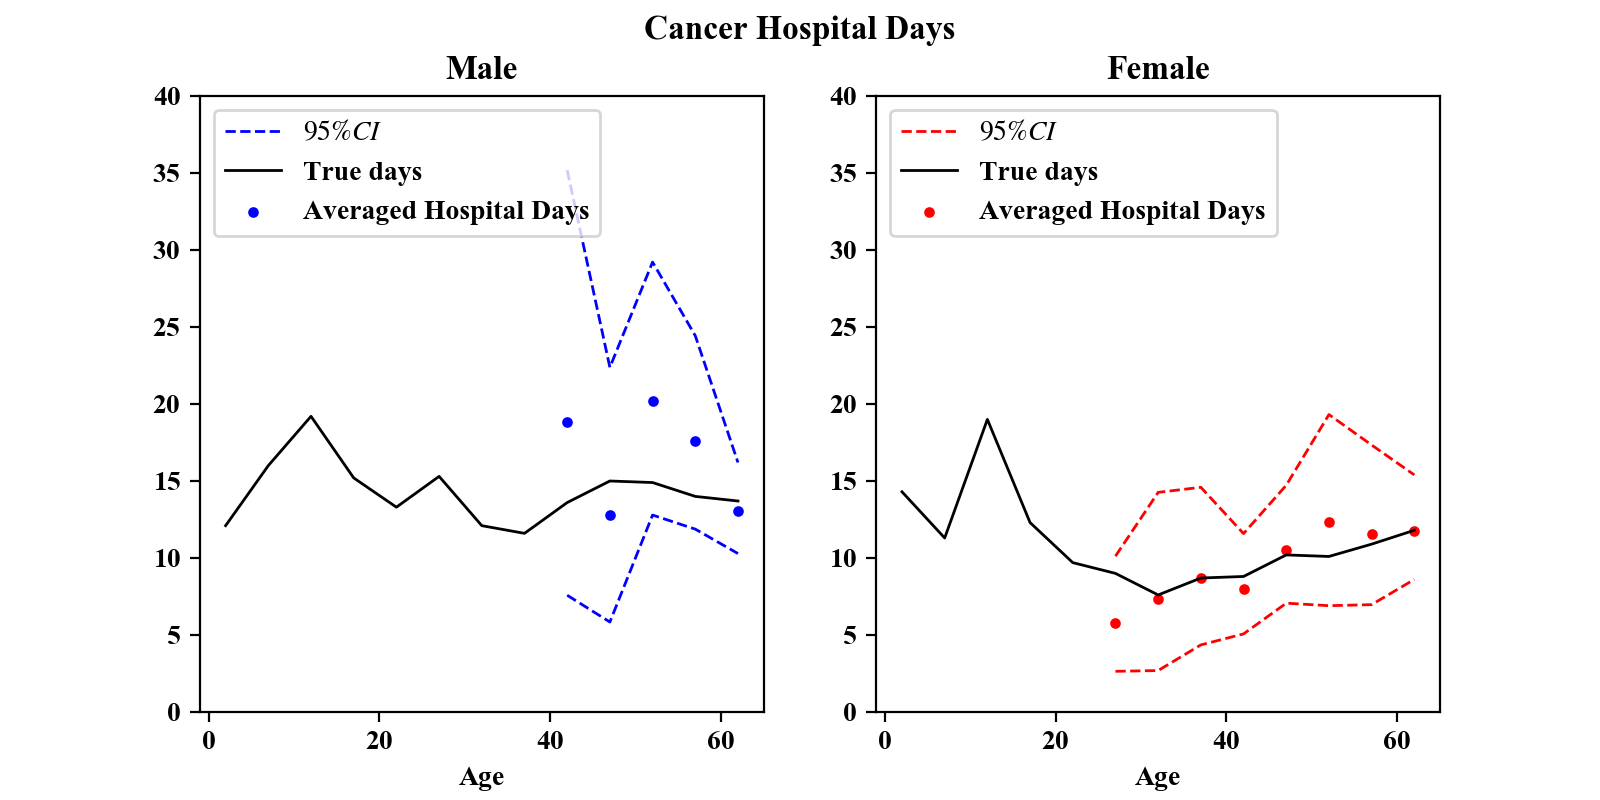

Text(0.5, 0.98, 'Cancer Hospital Days')

In [38]:
df = df_summary_5x.loc[(df_summary_5x.alb_mid < 65)]
df_M = df.loc[df.sex == 'M']
df_F = df.loc[df.sex == 'F']


def plot_days(ax, df_sex, color):
    ax.scatter(df_sex.alb_mid, df_sex.avg_days, c=color,
               s=8, label='Averaged Hospital Days')
    ax.plot(df_sex.alb_mid, df_sex.days_LCL, c=color,
            ls='--', lw=1, label=r'$95\% CI$')
    ax.plot(df_sex.alb_mid, df_sex.days_UCL, c=color, ls='--', lw=1)
    ax.plot(df_sex.alb_mid, df_sex.true_days,
            c='k', ls='-', lw=1, label='True days')
    ax.legend(loc='upper left')
    ax.set_ylim(0, 40)


fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
plot_days(ax1, df_M, 'b')
ax1.set_title('Male')
ax1.set_xlabel('Age')

ax2 = fig.add_subplot(122, sharey=ax1)
plot_days(ax2, df_F, 'r')
ax2.set_title('Female')
ax2.set_xlabel('Age')
fig.suptitle('Cancer Hospital Days')

### 「真の発生率」という表現について

## まとめ